# Optimization of a state-to-state transfer in a lambda system with RWA

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import qutip
from qutip import Qobj
%watermark -v --iversions

numpy       1.15.4
scipy       1.1.0
matplotlib  3.0.2
matplotlib.pylab  1.15.4
krotov      0.0.1
qutip       4.3.1
CPython 3.6.7
IPython 7.2.0


$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid #2\vphantom{#1}\right\rangle}
\newcommand{Ketbra}[2]{\left\vert#1\vphantom{#2} \right\rangle \hspace{-0.2em} \left\langle #2\vphantom{#1}\right\vert}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
\newcommand{toP}[0]{\omega_{12}}
\newcommand{toS}[0]{\omega_{23}}
\newcommand{oft}[0]{\left(t\right)}$

The purpose of this example is to illustrate and test the use of complex control fields.
Essentially, this is accomplished by rewriting the Hamiltonian as the sum of two independent controls (real and imaginary parts).

## Define the Hamiltonian

The system consists of three levels $\Ket{1}$, $\Ket{2}$ and $\Ket{3}$ with energy levels $E_{1}, E_{2}$ and $E_{3}$ which interact with a pair of pulses,
with time-dependent frequencies of $\omega_{P}=\omega_{P}\oft$ (pump laser) and 
$\omega_{S} = \omega_{S}\oft$ (stokes laser) respectively.
The pulses each have time-dependent envelopes $\varepsilon_{P}\oft$ and $\varepsilon_{S}\oft$.
Furthermore, it is assumed that the frequencies are tuned
such that $\omega_{P}=\omega_{P}\oft$ selectively addresses
the $\Ket{1} \leftrightarrow \Ket{2}$ and 
$\omega_{S}=\omega_{S}\oft$ addresses the $\Ket{2} \leftrightarrow \Ket{3}$ transition.

We transform into the interaction picture using the operator

$$\op{U}_{0} = \Ketbra{1}{1} e^{-i\left(E_{2} - \omega_{P} \right)t} + \Ketbra{2}{2} e^{-iE_{2}t} + \Ketbra{3}{3} e^{-i\left(E_{2}-\omega_{S}\right)t}\,\,,$$

where $\toP$ and $\toS$, the splittings between the first and second and between the second and third energy levels, are close to the central frequencies of $\omega_{S}\oft$
and $\omega_{P}\oft$.

In the rotating wave approximation, the fast rotating terms
$e^{\pm i\left(\toP + \omega_{P}\oft \right)t}$ and 
$e^{\pm i\left(\toS + \omega_{S}\oft \right)t}$ can be neglegted.
 
Consequently,

$$ \op{H}_{0} = \Delta_{P} \Ketbra{1}{1}  +\Delta_{S} \Ketbra{3}{3}$$

describes the drift Hamiltonian of a system with the respective detunings $\Delta_{P}=E_{1} + \omega_{P} - E_{2}$ and $\Delta_{S} = E_{3} + \omega_{S} -E_{2}$.

The control Hamiltonian is given by 

$$    \op{H}_{1}\oft = \op{H}_{1,P}\oft + \op{H}_{1,S}\oft = \Omega_{P}\oft \Ketbra{1}{2} + \Omega_{S}\oft\Ketbra{2}{3} + \text{h.c.}\,\,,$$

where $\Omega_{P} = \Omega_{P}\oft = \frac{\mu_{21} \varepsilon_{P}\oft}{2} e^{-i\Phi_{S}\oft t}$ and
$\Omega_{S} = \Omega_{S}\oft = \frac{\mu_{23} \varepsilon_{S}\oft}{2} e^{-i\Phi_{P}\oft t}$
with the phases $\Phi_{P}\oft = \toP - \omega_{P}\oft$ and $\Phi_{S}\oft = \toS - \omega_{S}\oft$
and $\mu_{ij}$ the $ij^{\text{th}}$ dipole-transition moment.

In order to optimize, we rewrite $\Omega_{P}\oft = \Omega_{P}^\text{Re}\oft + i\Omega_{P}^\text{Im}\oft$
and $\Omega_{S}\oft = \Omega_{S}^\text{Re}\oft + i\Omega_{S}^\text{Im}\oft$, such that optimization of the pulses involves only real functions.

In [2]:
def ham_and_states():
    """Lambda-system Hamiltonian"""
    E1 = 0.
    E2 = 10.
    E3 = 5.
    ω_P = 9.5
    ω_S = 4.5
    Ω_init = 5.
    H0 =  Qobj([[E1+ω_P-E2, 0., 0.], \
                [0., 0., 0.],        \
                [0., 0., E3+ω_S-E2]])
    
        
    H1P_re = Qobj([[0.,-1.,0.], [-1.,0.,0.],[0.,0.,0.]])    
    H1P_im = Qobj([[0.,-1.j,0.],[1.j,0.,0.],[0.,0.,0.]])
    ΩP_re = lambda t, args: Ω_init
    ΩP_im = lambda t, args: Ω_init
    
    H1S_re = Qobj([[0.,0.,0.],[0.,0.,1.],[0.,1.,0.]])
    H1S_im = Qobj([[0.,0.,0.],[0.,0.,1.j],[0.,-1.j,0.]])
    ΩS_re = lambda t, args: Ω_init    
    ΩS_im = lambda t, args: Ω_init
    
    """Initial and target states"""
    psi0 = qutip.Qobj(np.array([1.,0.,0.]))
    psi1 = qutip.Qobj(np.array([0.,0.,1.]))    
    
    return ([H0, \
            [H1P_re, ΩP_re], [H1P_im, ΩP_im], \
            [H1S_re, ΩS_re], [H1S_im, ΩS_im]], \
            psi0, psi1)

H, psi0, psi1 = ham_and_states()

We introduce projectors for each of the three energy levels
$\op{P}_{i} = \Ketbra{i}{i}$

In [3]:
proj1 = Qobj([[1.,0.,0.],[0.,0.,0.],[0.,0.,0.]])
proj2 = Qobj([[0.,0.,0.],[0.,1.,0.],[0.,0.,0.]])
proj3 = Qobj([[0.,0.,0.],[0.,0.,0.],[0.,0.,1.]])

## Define the optimization target

In the following we consider dynamics acting over a duration of $\Delta_{t} = 5$, beginning at
$t_{0} = 0$ and ending at $T = \Delta_{t}$. 
The time grid is divided into $n_{t} = 500$ equidistant time steps.

In [4]:
tlist = np.linspace(0.,5.,500)

Since the objective of this example is a state to state transfer from the initial state
$\Ket{\Psi_{\init}} = \Ket{1}$ into the final state $\Ket{\Psi_{\tgt}} = \Ket{3}$ at the
final time $t_{1}$, the optimization objective is set as

In [5]:
objective = krotov.Objective(initial_state=psi0, target_state=psi1, H=H)

## Initial guess shapes
"stimulated Raman adiabatic passage" (STIRAP) is a process in which population in $\Ket{1}$ is transferred into
$\Ket{3}$ without having to pass through $\Ket{2}$ (which could for instance be a rapidly decaying level).
In order for this process to occur, a temporally finite Stokes pulse of sufficient amplitude driving the $\Ket{2} \leftrightarrow \Ket{3}$ transition is applied first, whilst second pump pulse of similar intensity follows some time later such that the pulses still have a partial temporal overlap.

In order to demonstrate the Krotov's optimization method however, we choose an initial guess consisting of two low intensity and real Blackman pulses which are temporally disjoint.

For the real components of the matrix elements, we supply our guess pulses shaped as Blackman window functions `S(t,offset)`, with an offset ensuring that the two pulses don't overlap.
The imaginary components are coupled to pulses that are zero at all times.

In [6]:
def S(t,offset):
    """Shape envelope function for the field update"""
    return krotov.shapes.blackman(t,1.+offset,4.+offset)

def shape_field_real(eps,offset):
    """Applies the total pulse shape to the real part of a guess pulse"""
    field_shaped = lambda t, args: eps(t, args)*S(t,offset)
    return field_shaped

def shape_field_imag(eps,offset):
    """Initializes the imaginary parts of the guess pulses to zero"""
    field_shaped = lambda t, args: eps(t, args)*0.
    return field_shaped

H[1][1] = shape_field_real(H[1][1],1.) # Re[Ωₚ]
H[2][1] = shape_field_imag(H[2][1],1.) # Im[Ωₚ]
H[3][1] = shape_field_real(H[3][1],-1.) # Re[Ωₛ]
H[4][1] = shape_field_imag(H[4][1],-1.) # Im[Ωₛ]

We choose an appropriate update factor $\lambda_{a}$ for the problem at hand and make sure Krotov considers pulses which start and end with zero amplitude.

In [7]:
def update_shape(t):
    """Scales the Krotov methods update of the pulse value at the time t"""
    return krotov.shapes.flattop(t,0.,5.,0.3,func='sinsq')

In [8]:
opt_lambda = 2.
pulse_options = { 
    H[1][1]: krotov.PulseOptions(lambda_a=opt_lambda, shape=update_shape),
    H[2][1]: krotov.PulseOptions(lambda_a=opt_lambda, shape=update_shape),
    H[3][1]: krotov.PulseOptions(lambda_a=opt_lambda, shape=update_shape),
    H[4][1]: krotov.PulseOptions(lambda_a=opt_lambda, shape=update_shape)
}

We keep track of the fidelity during optimization by printing it after every iteration:

In [9]:
def print_fidelity(**args):
    F_re = np.average(np.array(args['tau_vals']).real)
    print("iter %d" % args['iteration'])
    print("   F = %f" % F_re)
    return F_re

## Simulate dynamics of the guess field

In [10]:
def plot_pulse(pulse, tlist, label):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('%s pulse amplitude' % label)
    plt.show(fig)

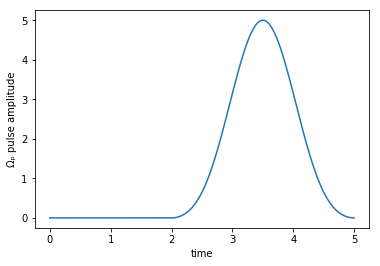

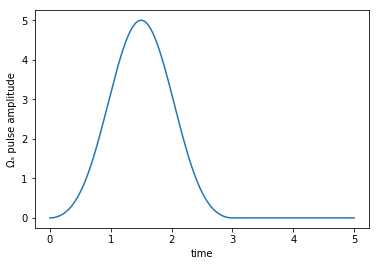

In [11]:
plot_pulse(H[1][1], tlist, 'Ωₚ')
plot_pulse(H[3][1], tlist, 'Ωₛ')

The imaginary parts are zero:

In [12]:
assert np.all([H[2][1](t, None) == 0 for t in tlist])
assert np.all([H[4][1](t, None) == 0 for t in tlist])

After assuring ourselves that our guess pulses appear as expected, we propagate the system using our guess. Since the pulses are temporally disjoint, we expect the first pulse to have no effect, whilst the second merely transfers population out of $\Ket{1}$ into $\Ket{2}$ and back again.

In [13]:
guess_dynamics = objective.mesolve(tlist, e_ops=[proj1,proj2,proj3])

In [14]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='1')
    ax.plot(result.times, result.expect[1], label='2')
    ax.plot(result.times, result.expect[2], label='3')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

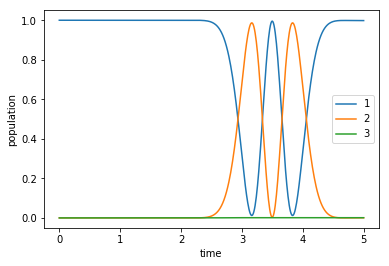

In [15]:
plot_population(guess_dynamics)

## Optimize
We now supply Krotov with all the information it needs to optimize, consisting of the `objectives` (maximize population in $\Ket{3}$ at $t_{1}$), `pulse_options` (the initial shapes of our pulses and how they may be changed) as well as the `propagator` to use, optimization functional (`chi_constructor`), `info_hook` (processing occuring inbetween iterations of optimization) and the number of iterations to perform, `iter_stop`.

In [16]:
oct_result = krotov.optimize_pulses(
    [objective], pulse_options, tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=krotov.info_hooks.chain(
        #krotov.info_hooks.print_debug_information,
        print_fidelity),
    iter_stop=15
)

iter 0
   F = -0.024948
iter 1
   F = 0.374064
iter 2
   F = 0.670285
iter 3
   F = 0.842325
iter 4
   F = 0.928357
iter 5
   F = 0.968191
iter 6
   F = 0.985995
iter 7
   F = 0.993839
iter 8
   F = 0.997279
iter 9
   F = 0.998790
iter 10
   F = 0.999456
iter 11
   F = 0.999752
iter 12
   F = 0.999885
iter 13
   F = 0.999945
iter 14
   F = 0.999973
iter 15
   F = 0.999986


We appear to have found pulse-shapes that fulfill our objective, but what do they look like?

pump pulse amplitude and phase:


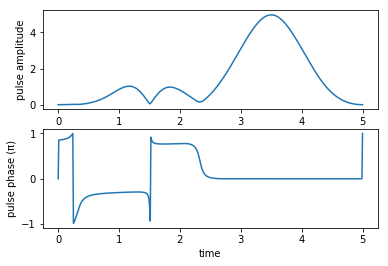

Stokes pulse amplitude and phase:


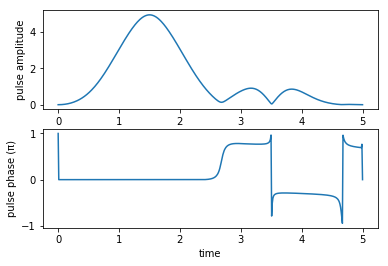

In [17]:
def plot_pulse_amplitude_and_phase(pulse_real, pulse_imaginary,tlist):
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    amplitudes = [np.sqrt(x*x + y*y) for x,y in zip(pulse_real,pulse_imaginary)]
    phases = [np.arctan2(y,x)/np.pi for x,y in zip(pulse_real,pulse_imaginary)]
    ax1.plot(tlist,amplitudes)
    ax1.set_xlabel('time')
    ax1.set_ylabel('pulse amplitude')
    ax2.plot(tlist,phases)
    ax2.set_xlabel('time')
    ax2.set_ylabel('pulse phase (π)')    
    plt.show()
    
print("pump pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    oct_result.optimized_controls[0], oct_result.optimized_controls[1], tlist)
print("Stokes pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    oct_result.optimized_controls[2], oct_result.optimized_controls[3], tlist)

And how does the population end up in $\Ket{3}$?

In [18]:
opt_dynamics = oct_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj1, proj2, proj3])

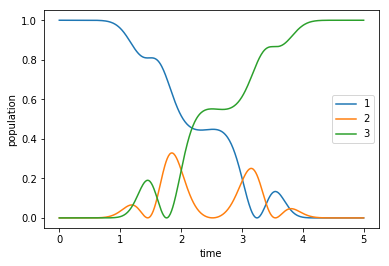

In [19]:
plot_population(opt_dynamics)